# Instalação de dependências

Neste projeto é usado algumas bibliotecas para poder realizar a extração e análise das entidades da categoria Mercado no primeiro trimestre de 2015 do Folha UOL News Dataset. Estas bibliotecas são listadas abaixo:

In [1]:
!uv pip install -q transformers[torch]
!uv pip install -q kaggle
!uv pip install -q pandas
!uv pip install -q tqdm
!uv pip install -q seaborn
!uv pip install -q matplotlib

zsh:1: no matches found: transformers[torch]


# Download do dataset

Nesta etapa, é feita o download do dataset `https://www.kaggle.com/datasets/marlesson/news-of-the-site-folhauol`. Caso não deseje utilizar o Kaggle para fazer este download, pode-se fazer o download manualmente do arquivo .zip e salvar na raiz desse projeto para dar continuidade.

In [2]:
!kaggle datasets download --force -d marlesson/news-of-the-site-folhauol

Dataset URL: https://www.kaggle.com/datasets/marlesson/news-of-the-site-folhauol
License(s): CC0-1.0
  0%|                                                | 0.00/187M [00:00<?, ?B/s]
100%|████████████████████████████████████████| 187M/187M [00:00<00:00, 3.70GB/s]


# Importação de dependências

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from collections import Counter

# Carregamento do dataset

Nesta seção é realizado o carregamento do dataset em um Pandas dataframe.

In [4]:
def load_dataset(path: str) -> pd.DataFrame:
    """
    Load the data from the path.
    """
    return pd.read_csv(path)

In [5]:
df = load_dataset("news-of-the-site-folhauol.zip")

# Filtragem do dataset

O dataset precisa ser filtrado pelo primeiro trimestre de 2015 e pela categoria 'Mercado'.

In [6]:
def filter_news_by_date_and_category(df: pd.DataFrame, date_start: str, date_end: str, category: str) -> pd.DataFrame:
    """
    Filter the news by date and category.
    """
    df_with_converted_date = df.copy()
    date_column_name = 'date'
    category_column_name = 'category'
    df_with_converted_date[date_column_name] = pd.to_datetime(df_with_converted_date[date_column_name])
    filtered_df = df_with_converted_date[(df_with_converted_date[date_column_name] >= date_start) & (df_with_converted_date[date_column_name] <= date_end) & (df_with_converted_date[category_column_name] == category)]
    return filtered_df.dropna(subset=['text'])

In [7]:
filtered_df = filter_news_by_date_and_category(df, '2015-01-01', '2015-03-31', 'mercado')

print(filtered_df['date'].agg(['min', 'max']))
print('-' * 100)
print(filtered_df['category'].value_counts())

min   2015-01-01
max   2015-03-31
Name: date, dtype: datetime64[ns]
----------------------------------------------------------------------------------------------------
category
mercado    2111
Name: count, dtype: int64


In [8]:
filtered_df.head()

,title,text,date,category,subcategory,link
99055,Prioridade ao pós-pago reduz número de linhas ...,"O mercado de telefonia celular perdeu 2,09 mil...",2015-03-12,mercado,NaN,http://www1.folha.uol.com.br/mercado/2015/12/1...
99063,Dilma sanciona meta fiscal e governo liberará ...,A presidente Dilma Rousseff sancionou a altera...,2015-03-12,mercado,NaN,http://www1.folha.uol.com.br/mercado/2015/12/1...
99064,Reportagem da Folha sobre investidor mais jove...,"A reportagem da Folha ""Príncipe da Bolsa"", de ...",2015-03-12,mercado,NaN,http://www1.folha.uol.com.br/mercado/2015/12/1...
99074,Impeachment pode prejudicar ajuste fiscal no B...,A abertura do processo de impeachment da presi...,2015-03-12,mercado,NaN,http://www1.folha.uol.com.br/mercado/2015/12/1...
99076,Petrobras anuncia 2º reajuste no preço do gás ...,A Petrobras comunicou ao mercado novo reajuste...,2015-03-12,mercado,NaN,http://www1.folha.uol.com.br/mercado/2015/12/1...


In [9]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2111 entries, 99055 to 167025
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   title        2111 non-null   object        
 1   text         2111 non-null   object        
 2   date         2111 non-null   datetime64[ns]
 3   category     2111 non-null   object        
 4   subcategory  0 non-null      object        
 5   link         2111 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 115.4+ KB


# Configuração do NER pipeline

Neste trecho de código é configurado a pipeline de NER usando a biblioteca transformers da Hugging Face com o modelo `monilouise/ner_pt_br` que é pré-treinado em português. A utilização dos módulos AutoTokenizer, AutoModelForTokenClassification e pipeline servem para poder carregar o tokenizador compatível com o modelo, carregar o modelo pré-treinado para classificação dos tokens e criar a pipeline de NER.

O `aggregation_strategy` foi definido como `max` porque nos testes foi o que teve a melhor eficiência. Com esta estratégia os subtokens são juntos em uma única entidade e considera aquele com maior pontuação de confiança para representar a entidade final.

In [10]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
model_name = 'monilouise/ner_pt_br'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)
ner_pipeline = pipeline(
    'ner', 
    model=model, 
    tokenizer=tokenizer, 
    aggregation_strategy="max",
)


Some weights of the model checkpoint at monilouise/ner_pt_br were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0


# Extração de entidades do tipo Organização

Abaixo é realizada a extração de entidades do tipo Organização usando a pipeline de NER que foi configurada acima. 

`get_entities_from_news_texts`: O modelo é executado em cada um dos textos (das notícias) que existem no dataset onde é extraído todas as entidades de cada texto.
`extract_organization_entities_from_news`: Com as entidades extraídas de cada texto, elas são filtradas de tal forma que se obtém somente as entidades do tipo "ORG" (Organização) e também são filtrados entidades não relevantes ou duplicadas (como entidades que são uma única palavra, ou entidades que aparecem separadas tipo 'BM &' e 'FBovespa' que representam a mesma entidade na verdade).
`normalize_organization_name`: Normaliza o nome da organização, removendo final com aspas simples, ou convertendo nomes para nomes mais apropriados, por exemplo: Sete se refere à empresa Sete Brasil.



In [11]:
def get_entities_from_news_texts(news_texts: list[str]) -> list[str]:
    """
    Get the entities from the news.
    """
    return [ner_pipeline(text) for text in tqdm(news_texts)]

In [12]:
def normalize_organization_name(organization_name: str) -> str:
    """
    Normalize the organization name.
    """
    name = organization_name.strip(" '\"").replace('\n', ' ').strip()

    merge_map = {
        'S &': 'S&P',
        'BM &': 'BM&FBovespa',
        'Sete': 'Sete Brasil',
        'Moody': 'Moody\'s',
    }
    return merge_map.get(name, name)

In [13]:
def is_valid_organization_name(organization_name: str) -> bool:
    """
    Check if the organization name is valid.
    """
    if (len(organization_name) < 2):
        return False
    if organization_name.lower() in {'s', 'p', 'fbovespa', 'folha', 'brasil', 'investimentos', 'carros', 'corretora', 'açúcar', 'banco do'}:
        return False
    return True

In [14]:
def extract_organization_entities_from_news(news_entities) -> list[str]:
    """
    Extract only organization entities from news entities.
    """
    entities_list = []
    
    for entities in news_entities:
        for entity in entities:
            if entity['entity_group'] == 'ORG' and is_valid_organization_name(entity['word']):
                entities_list.append(normalize_organization_name(entity['word']))

    return entities_list

In [15]:
news_entities = get_entities_from_news_texts(filtered_df['text'])

  0%|          | 0/2111 [00:00<?, ?it/s]

In [16]:
organizations = extract_organization_entities_from_news(news_entities)

# Exibição das principais entidades do tipo Organização

Este código define uma função chamada `show_top_organizations` que recebe uma lista de nomes de organizações extraídas de um processo de NER e exibe as organizações mais mencionadas por frequência em formato de gráfico de barras horizontal. Primeiro, ele conta quantas vezes cada organização aparece usando Counter e ordena esses dados em ordem decrescente. Em seguida, cria um DataFrame do Pandas com essas informações e utiliza a biblioteca Seaborn para gerar o gráfico.

In [17]:
def show_top_organizations(organizations: list[str], number_of_organizations: int = 20) -> None:
    """
    Show the top organizations by frequency.
    """
    organizations_df = pd.DataFrame(sorted(Counter(organizations).items(), key=lambda x: x[1], reverse=True), columns=['Organização', 'Frequência'])

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(data=organizations_df.head(number_of_organizations), x='Frequência', y='Organização', palette='viridis')

    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

    plt.title(f'Top {number_of_organizations} Organizações mais mencionadas (Seção Mercado - Jan-Mar 2015)')
    plt.xlabel('Número de menções')
    plt.ylabel('Organização')
    plt.tight_layout()
    plt.show()


/var/folders/_z/2mdksj291s782py9yt8kqq1r0000gn/T/ipykernel_41072/745446555.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=organizations_df.head(number_of_organizations), x='Frequência', y='Organização', palette='viridis')


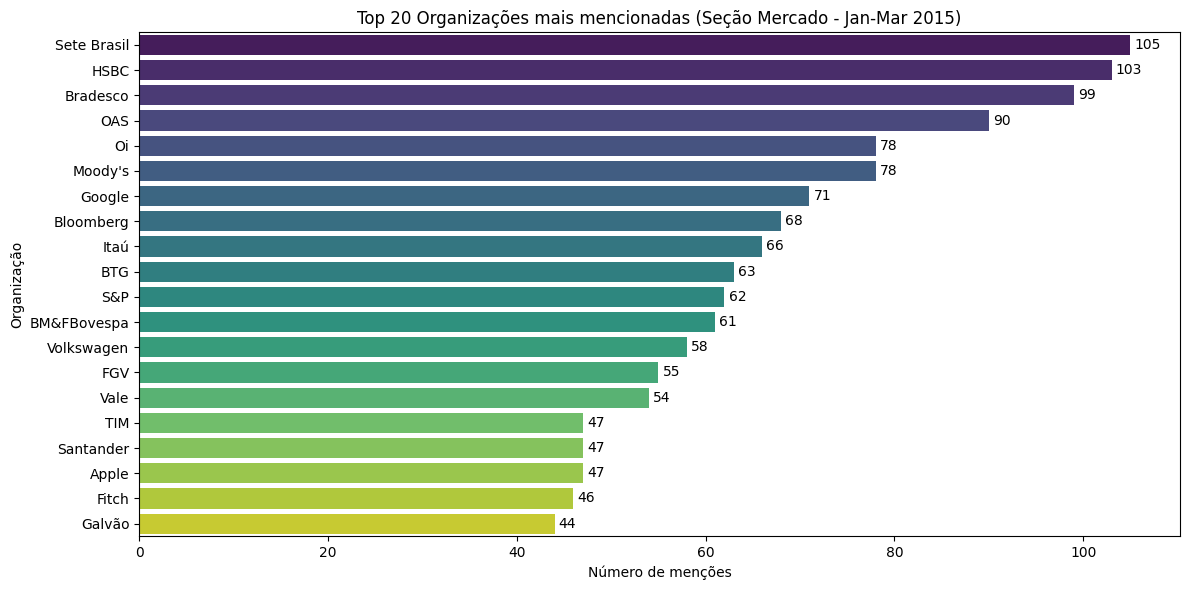

In [18]:
show_top_organizations(organizations, number_of_organizations=20)